In [1]:
import numpy as np 
import pandas as pd
import h5py
import matplotlib.pyplot as plt 
import seaborn as sns
from mat73 import loadmat 
from scipy.signal import find_peaks


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Masking, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Masking
from tensorflow.keras import Model, Input
import tensorflow as tf
from tcn import TCN
from sklearn.model_selection import train_test_split

import wandb
from wandb.keras import WandbEvalCallback, WandbCallback,  WandbMetricsLogger, WandbModelCheckpoint

ECG, PPG, ABP = 0,1,2

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: emilierp2000 (emilierp). Use `wandb login --relogin` to force relogin


True

# Dataset

- 10s segments of 125 Hz
- PPG is one specific type of BVP measurement. 

In [3]:
f = h5py.File('D:/PulseDB/Segment_Files/PulseDB_MIMIC/p000160.mat','r')
print(f.keys())
refs = f.get('#refs#')
print(refs.keys())
subj = f.get('Subj_Wins')
print(subj.keys())
print("PPG: ", subj['PPG_Raw'].shape, len(subj['PPG_Raw'][0]))

# for name, var in subj.items():
#     print(name, var.shape)

<KeysViewHDF5 ['#refs#', 'Subj_Wins']>
<KeysViewHDF5 ['0', '0A', '0B', '0C', '0D', '0b', '0c', '0d', '0e', '0f', '0g', '0h', '0i', '0j', '0k', '0l', '0m', '0n', '0o', '0p', '0q', '0r', '0s', '0t', '0u', '0v', '0w', '0x', '0y', '0z', '1', '1A', '1B', '1C', '1D', '1b', '1c', '1d', '1e', '1f', '1g', '1h', '1i', '1j', '1k', '1l', '1m', '1n', '1o', '1p', '1q', '1r', '1s', '1t', '1u', '1v', '1w', '1x', '1y', '1z', '2', '2A', '2B', '2C', '2D', '2b', '2c', '2d', '2e', '2f', '2g', '2h', '2i', '2j', '2k', '2l', '2m', '2n', '2o', '2p', '2q', '2r', '2s', '2t', '2u', '2v', '2w', '2x', '2y', '2z', '3', '3A', '3B', '3C', '3D', '3b', '3c', '3d', '3e', '3f', '3g', '3h', '3i', '3j', '3k', '3l', '3m', '3n', '3o', '3p', '3q', '3r', '3s', '3t', '3u', '3v', '3w', '3x', '3y', '3z', '4', '4A', '4B', '4C', '4D', '4b', '4c', '4d', '4e', '4f', '4g', '4h', '4i', '4j', '4k', '4l', '4m', '4n', '4o', '4p', '4q', '4r', '4s', '4t', '4u', '4v', '4w', '4x', '4y', '4z', '5', '5A', '5B', '5C', '5D', '5b', '5c', '5d', '5e'

In [4]:
data = loadmat('D:/PulseDB/Segment_Files/PulseDB_MIMIC/p000160.mat')['Subj_Wins']
print(data.keys())
ppg = data['PPG_F']
abp = data['ABP_Raw']
print(data['SubjectID'][0], len(ppg), len(ppg[0]), len(ppg[0][0]))

dict_keys(['ABP_F', 'ABP_Lag', 'ABP_Raw', 'ABP_SPeaks', 'ABP_Turns', 'Age', 'CaseID', 'ECG_F', 'ECG_RPeaks', 'ECG_Raw', 'Gender', 'IncludeFlag', 'PPG_ABP_Corr', 'PPG_F', 'PPG_Raw', 'PPG_SPeaks', 'PPG_Turns', 'SegDBP', 'SegSBP', 'SegmentID', 'SubjectID', 'WinID', 'WinSeqID'])
['p000160'] 82 1 1250


In [5]:
def Build_Dataset(Path,FieldName='Subset'):
        Data=loadmat(Path)
        # Access 10-s segments of ECG, PPG and ABP signals
        Signals=Data[FieldName]['Signals']
        # Access SBP labels of each 10-s segment
        SBPLabels=Data[FieldName]['SBP']
        # Access Age of the subject corresponding to each of the 10-s segment
        Age=Data[FieldName]['Age']
        # Access Gender of the subject corresponding to each of the 10-s segment
        Gender=np.array(Data[FieldName]['Gender']).squeeze()
        # Convert Gender to numerical 0-1 labels
        Gender=(Gender=='M').astype(float)
        # Access Height and Weight of the subject corresponding to each of the 10-s segment
        # If the subject is from the MIMIC-III matched subset, height and weight will be NaN 
        # since they were only recorded in VitalDB
        Height=Data[FieldName]['Height']
        Weight=Data[FieldName]['Weight']
        # Concatenate the demographic information as one matrix
        Demographics=np.stack((Age,Gender,Height,Weight),axis=1)
        return Data,Signals,SBPLabels,Demographics
        
Data,Signals,SBPLabels,Demographics = Build_Dataset('D:/PulseDB/Subset_Files/Train_Subset.mat')
TestData, TestSignals, TestSBPLabels, TestDemographics = Build_Dataset('D:/PulseDB/Subset_Files/AAMI_Test_Subset.mat')

In [6]:
print(Data.keys(), Data['Subset'].keys())
print("Demographics: ", Demographics.shape, "(age, gender, height, weight)")
print("True label:", SBPLabels.shape, ", Data: ",Data['Subset']['Signals'].shape, len(Data['Subset']['Subject']))
# 902160 segments, 10s each, 125Hz sampling rate

def get_subject_segment(Data, SBPLabels):
    # Unique Subject IDs
    subjects = np.array(Data['Subset']['Subject']).squeeze()
    subject_ids = np.unique(list(filter(None, subjects)))

    # find segments corresponding to a particular subject
    indices = dict()
    for subject in subject_ids:
        indices[subject] = [index for index, value in enumerate(Data['Subset']['Subject']) if value[0] == subject]

    return subjects, subject_ids, indices

TrainSubjects, TrainSubject_ids, TrainIndices = get_subject_segment(Data, SBPLabels)
print("(Train) Number of different subjects (subject_ids):", TrainSubject_ids.size, TrainSubject_ids[0])
TestSubjects, TestSubject_ids, TestIndices = get_subject_segment(TestData, TestSBPLabels)
print("(Test) Number of different subjects (subject_ids):", TestSubject_ids.size, TestSubject_ids[0])

# get segments for a particular subject
idx = 0
subject = Data['Subset']['Subject'][idx][0]
segment_indices = TrainIndices[subject] # get index of segment in indices
signal = Signals[segment_indices]
label = SBPLabels[segment_indices]
print("Data and true label shape: (125 Hz * 10s = 1250 samples, 360 windows, 3 signals ECG,PPG,ABP)", signal.shape, label.shape)

dict_keys(['Subset']) dict_keys(['Age', 'BMI', 'DBP', 'Gender', 'Height', 'SBP', 'Signals', 'Subject', 'Weight'])
Demographics:  (902160, 4) (age, gender, height, weight)
True label: (902160,) , Data:  (902160, 3, 1250) 902160
(Train) Number of different subjects (subject_ids): 290 p000001_1
(Test) Number of different subjects (subject_ids): 16 p000238_1
Data and true label shape: (125 Hz * 10s = 1250 samples, 360 windows, 3 signals ECG,PPG,ABP) (360, 3, 1250) (360,)


In [7]:
train_size = len(TrainSubject_ids) # 10
test_size = len(TestSubject_ids) # 5

def build_dataset(subject_ids, nb_subjects, Indices, Signals, SBPLabels):
    _tot_segments = 0
    subjects = {}
    ppg = []
    bp = []
    for subject in subject_ids[:nb_subjects]:
        segment_indices = Indices[subject]
        subjects[subject] = [_tot_segments,_tot_segments+len(segment_indices)-1]
        _tot_segments += len(segment_indices)
        ppg.extend(Signals[segment_indices][:,PPG,:])
        bp.extend(SBPLabels[segment_indices])
    return subjects, ppg, bp

TrainSubjects, TrainPPG, TrainBP = build_dataset(TrainSubject_ids, train_size, TrainIndices, Signals, SBPLabels)
TestSubjects, TestPPG, TestBP = build_dataset(TestSubject_ids, test_size, TestIndices, TestSignals, TestSBPLabels)
        
print(f"Train PPG Signal {TrainPPG[0].shape} : {len(TrainPPG) / 360} subjects, 360 segments, {len(TrainPPG[0])} samples per segment")
print(f"Train SBP Label {TrainBP[0].shape} : {len(TrainBP) / 360} subjects, {len(TrainBP)} segments in total")
print(f"Test PPG Signal {TestPPG[0].shape} : {len(TestSubjects)} subjects, different segments per id, {len(TestPPG[0])} samples per segment")
print(f"Test SBP Label {TestBP[0].shape} : {len(TestSubjects)} subjects, {len(TestBP)} segments in total")

Train PPG Signal (1250,) : 290.0 subjects, 360 segments, 1250 samples per segment
Train SBP Label () : 290.0 subjects, 104400 segments in total
Test PPG Signal (1250,) : 16 subjects, different segments per id, 1250 samples per segment
Test SBP Label () : 16 subjects, 97 segments in total


Age: 22.0, Gender: 1.0, Height: nan cm, Weight: nan kg


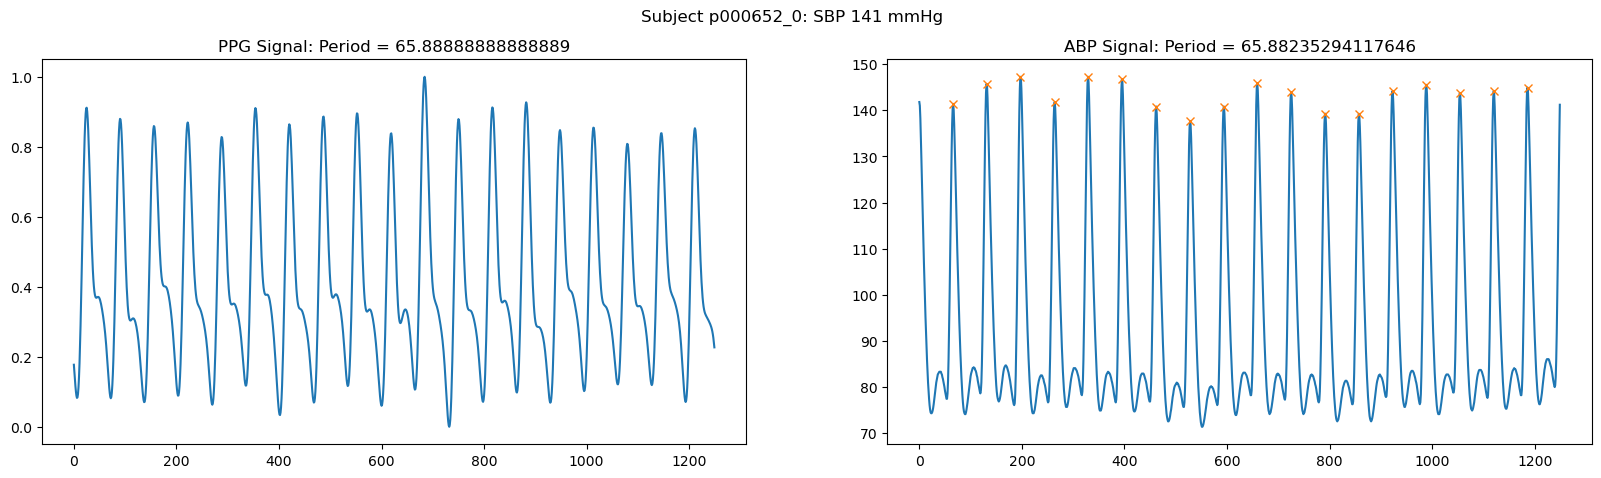

I don't get it because the mean from the peaks is  143.33994568010363  mmHg


In [8]:
subject_index = np.random.choice(len(TrainSubject_ids))
signal_index = np.random.choice(360) # 0-359
index = TrainIndices[TrainSubject_ids[subject_index]][signal_index]

ECG, PPG, ABP = 0,1,2
Age, Gender, Height, Weight = 0,1,2,3
subject = TrainSubject_ids[subject_index]
# gender: 1 is Male
print(f"Age: {Demographics[index][Age]}, Gender: {Demographics[index][Gender]}, Height: {Demographics[index][Height]} cm, Weight: {Demographics[index][Weight]} kg")

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
peaks, _ = find_peaks(Signals[index][ABP], height=90, distance=50)
axs[0].plot(Signals[index][PPG])
axs[0].set_title(f"PPG Signal: Period = {np.mean(np.diff(find_peaks(Signals[index][PPG], height=0.7, distance=50)[0]))}")
axs[1].plot(Signals[index][ABP])
plt.plot(peaks, Signals[index][ABP][peaks], "x")
axs[1].set_title(f"ABP Signal: Period = {np.mean(np.diff(peaks))}")
plt.suptitle(f"Subject {TrainSubject_ids[subject_index]}: SBP {int(SBPLabels[index])} mmHg")
plt.show()

print("I don't get it because the mean from the peaks is ", np.mean(Signals[index][ABP][peaks]), " mmHg")

In [9]:
X_train, X_test, y_train, y_test = np.array(TrainPPG), np.array(TestPPG), np.array(TrainBP), np.array(TestBP)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_train.shape)

(83520, 1250)


# Model

Here are some of my notes regarding my experience using TCN:

- nb_filters: Present in any ConvNet architecture. It is linked to the predictive power of the model and affects the size of your network. The more, the better unless you start to overfit. It's similar to the number of units in an LSTM/GRU architecture too.

- kernel_size: Controls the spatial area/volume considered in the convolutional ops. Good values are usually between 2 and 8. If you think your sequence heavily depends on t-1 and t-2, but less on the rest, then choose a kernel size of 2/3. For NLP tasks, we prefer bigger kernel sizes. A large kernel size will make your network much bigger.

- dilations: It controls how deep your TCN layer is. Usually, consider a list with multiple of two. You can guess how many dilations you need by matching the receptive field (of the TCN) with the length of features in your sequence. For example, if your input sequence is periodic, you might want to have multiples of that period as dilations.

- nb_stacks: Not very useful unless your sequences are very long (like waveforms with hundreds of thousands of time steps).

- padding: I have only used causal since a TCN stands for Temporal Convolutional Networks. Causal prevents information leakage.

- use_skip_connections: Skip connections connects layers, similarly to DenseNet. It helps the gradients flow. Unless you experience a drop in performance, you should always activate it.

- return_sequences: Same as the one present in the LSTM layer. Refer to the Keras doc for this parameter.

- dropout_rate: Similar to recurrent_dropout for the LSTM layer. I usually don't use it much. Or set it to a low value like 0.05.

- activation: Leave it to default. I have never changed it.

- kernel_initializer: If the training of the TCN gets stuck, it might be worth changing this parameter. For example: glorot_uniform.

- use_batch_norm, use_weight_norm, use_weight_norm: Use normalization if your network is big enough and the task contains enough data. I usually prefer using use_layer_norm, but you can try them all and see which one works the best.

In [10]:
tf.keras.backend.clear_session()

def build_model(nb_stacks=1, nb_filters=64, kernel_size=5, dilations=[1,8,16,32,64, 128], dropout_rate=0):
    model = Sequential([
        Input(shape=(None, 1)),
        TCN(input_shape=(None, 1), nb_stacks=nb_stacks, nb_filters=nb_filters, kernel_size=kernel_size, dilations=dilations, dropout_rate=dropout_rate),
        Dense(1, activation='linear')
    ])
    return model

# # Modify your model to include a Masking layer
# model = Sequential([
#     Input(shape=(None, 1)),
#     # Masking(mask_value=0.0, input_shape=(None, 1)),  # Assuming your input is 1-dimensional
#     TCN(input_shape=(None, 1), nb_stacks=2, nb_filters=64, kernel_size=5, dilations=[1, 8, 16, 32, 64]),
#     Dense(1, activation='linear') ## TODO regression, activation = linear dakke ?
# ])

model = build_model()
# input_shape : (batch_size, sequence_lengths, input_dim)
model.summary()
# The receptive field tells you how far the model can see in terms of timesteps.
# if time_steps > tcn_layer.receptive_field, then we should not be able to solve this task.
# time_steps = 1250
print('Receptive field size =', model.layers[0].receptive_field)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 64)                226496    
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 226,561
Trainable params: 226,561
Non-trainable params: 0
_________________________________________________________________
Receptive field size = 1993


In [127]:
tf.keras.backend.clear_session()

# Modify your model to include a Masking layer
model = Sequential([
    Input(shape=(None, 1)),
    # Masking(mask_value=0.0, input_shape=(None, 1)),  # Assuming your input is 1-dimensional
    TCN(input_shape=(None, 1), nb_filters=64, kernel_size=5, dilations=[1, 2, 4, 8, 16, 32]),
    Dense(1, activation='linear') ## TODO regression, activation = linear dakke ?
])

# input_shape : (batch_size, sequence_lengths, input_dim)
model.summary()
# The receptive field tells you how far the model can see in terms of timesteps.
# if time_steps > tcn_layer.receptive_field, then we should not
# be able to solve this task.
print('Receptive field size =', model.layers[0].receptive_field)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 64)                390848    
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 390,913
Trainable params: 390,913
Non-trainable params: 0
_________________________________________________________________
Receptive field size = 1937


In [108]:
inputs = Input(shape=(None, 1))
x = TCN(16)(inputs)
x = Dropout(0.5)(x)
# x = tf.reshape(x, shape=(None, None, 16), name='idk')
x = TCN(32)(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='linear')(x)
model = Model(inputs=[inputs], outputs=[x])
model.summary()

TypeError: Exception encountered when calling layer "tf.reshape_1" (type TFOpLambda).

Failed to convert elements of (None, None, 16) to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.

Call arguments received by layer "tf.reshape_1" (type TFOpLambda):
  • tensor=tf.Tensor(shape=(None, 16), dtype=float32)
  • shape=('None', 'None', '16')
  • name='idk'

# Train Model

## Single run

In [146]:
configs = dict(
    num_classes = 1,
    shuffle_buffer = 1024,
    batch_size = 64,
    earlystopping_patience = 10,
    learning_rate = 1e-3,
    epochs = 50
)

optimizer = tf.keras.optimizers.Adam(learning_rate=configs['learning_rate'])
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'],)

earlystopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=configs['earlystopping_patience'], verbose=0, mode='auto',
    restore_best_weights=True
)

## Initialize a W&B run
# run = wandb.init(
#     project = "ppg-bp",
#     config = configs
# )

In [135]:
# Train your model
history = model.fit(
    X_train, y_train,
    epochs = configs["epochs"],
    validation_data = (X_val, y_val),
    verbose = 1, 
    callbacks=[earlystopper,
            #    WandbCallback(validation_data=(X_val[:10], y_val[:10]), labels=["SBP"]), 
               ]
)

# Close the W&B run
# run.finish()

In [136]:
# Evaluate the model
y_pred = model.predict(X_test).squeeze()
result = model.evaluate(X_test, y_test)
print(f"Test MAE : {result[1]:.2f}")
print(f"Test Loss (MSE) : {result[0]:.2f}")

1/1 [==============================] - 0s 29ms/step - loss: 825.9877 - mean_absolute_error: 24.6558
Test MAE : 24.66
Test Loss (MSE) : 825.99


## Sweep

In [11]:
sweep_config = {
    'method': 'random', # grid, random, bayes
    "metric": {"goal": "minimize", "name": "val_mean_absolute_error"},
    'early_terminate': {'type': 'hyperband','min_iter': 5,},
    }
parameters_dict = {
    'dropout': {
          'values': [0.05, 0]
      },
    'nb_filters': {
        'values': [32, 64]
      },
    'kernel_size': {
        'values': [5, 7]
      },
    'nb_stacks': {
        'values': [1, 2]
    },
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0.001,
        'max': 0.1
      },
    'batch_size': {
        'values': [64, 128]
      },
    'epochs': {
        'value': 50,
    },
    }
sweep_config['parameters'] = parameters_dict

import pprint
pprint.pprint(sweep_config)

{'early_terminate': {'min_iter': 5, 'type': 'hyperband'},
 'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'val_mean_absolute_error'},
 'parameters': {'batch_size': {'values': [64, 128]},
                'dropout': {'values': [0.05, 0]},
                'epochs': {'value': 50},
                'kernel_size': {'values': [5, 7]},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.1,
                                  'min': 0.001},
                'nb_filters': {'values': [32, 64]},
                'nb_stacks': {'values': [1, 2]}}}


In [12]:
def train(model, batch_size=64, epochs=10, lr=1e-3, log_freq=10):  
    
    tf.keras.backend.clear_session()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'],)

    # # callback setup
    # wandb_callbacks = [
    #     WandbMetricsLogger(log_freq=log_freq),
    #     # WandbModelCheckpoint(filepath="my_model_{epoch:02d}")
    # ]
    earlystopper = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, verbose=0, mode='auto',
        restore_best_weights=True
    )

    model.fit(X_train, y_train,
              batch_size=batch_size, 
              epochs=epochs, 
              validation_data=(X_val, y_val), 
              callbacks=[
                #   earlystopper,
                  WandbCallback(), 
               ],
               verbose=0)

In [13]:
def sweep_train(config_defaults=None):
    # Initialize wandb with a sample project name
    with wandb.init(config=config_defaults):  # this gets over-written in the Sweep

        # initialize model
        model = build_model(
            nb_stacks=wandb.config.nb_stacks,
            nb_filters=wandb.config.nb_filters,
            kernel_size=wandb.config.kernel_size,
            dilations=[1, 2, 4, 8, 16, 32],
            dropout_rate=wandb.config.dropout
            )
        # model = Sequential([
        #     Input(shape=(None, 1)),
        #     # Masking(mask_value=0.0, input_shape=(None, 1)),  # Assuming your input is 1-dimensional
        #     TCN(input_shape=(None, 1), nb_filters=64, kernel_size=3, dilations=[1, 2, 4, 8, 16, 32]),  # Allow variable sequence length
        #     Dropout(wandb.config.dropout),
        #     Dense(1, activation='linear') ## TODO regression, activation = linear dakke ?
        # ])

        train(model, 
              wandb.config.batch_size, 
              wandb.config.epochs,
              wandb.config.learning_rate,)

In [14]:
# Initialize sweep
sweep_id = wandb.sweep(sweep_config, project="sweep-test")
# Run sweep agent
wandb.agent(sweep_id, function=sweep_train, count=30)

INFO:tensorflow:Assets written to: c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_142908-pptifsoq\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_142908-pptifsoq\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_142908-pptifsoq\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_142908-pptifsoq\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_142908-pptifsoq\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_142908-pptifsoq\files\model-best)... Done. 0.0s


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂▇▃█▆█▃▆▅▂▂▄▂▂▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▃▇▂█▅█▃▅▅▂▂▃▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁
best_epoch,45
best_val_loss,385.75034
epoch,49
loss,440.65359
mean_absolute_error,16.70805
val_loss,387.47656


wandb: Agent Starting Run: 39g6fosg with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.05
wandb: 	epochs: 50
wandb: 	kernel_size: 7
wandb: 	learning_rate: 0.016905702722014294
wandb: 	nb_filters: 64
wandb: 	nb_stacks: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


INFO:tensorflow:Assets written to: c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\erolland\Documents\pyVHR\project_ml\wandb\run-20231213_151159-39g6fosg\files\model-best)... Done. 0.0s


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▄█▅▁▂▃▂▁▃▁▂▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
val_mean_absolute_error,▅▄█▅▂▂▃▂▂▃▁▂▁▁▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
best_epoch,18
best_val_loss,376.96817
epoch,49
loss,410.59531
mean_absolute_error,16.19879
val_loss,407.26752


wandb: Agent Starting Run: mjijxpm9 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.05
wandb: 	epochs: 50
wandb: 	kernel_size: 7
wandb: 	learning_rate: 0.06077195777090287
wandb: 	nb_filters: 64
wandb: 	nb_stacks: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch,49
loss,nan
mean_absolute_error,nan
val_loss,nan
val_mean_absolute_error,nan


In [ ]:
best_run = sweep_id.best_run() 

In [ ]:
# Save Model

# model.save('/models/tcn_model_2d_noise.h5')

# Evaluate Model

In [125]:
# Evaluate the model
y_pred = model.predict(X_test).squeeze()
result = model.evaluate(X_test, y_test)
print(f"Test MAE : {result[1]:.2f}")
print(f"Test Loss (MSE) : {result[0]:.2f}")

1/1 [==============================] - 0s 16ms/step - loss: 761.2321 - mean_absolute_error: 21.7134
Test MAE : 21.71
Test Loss (MSE) : 761.23


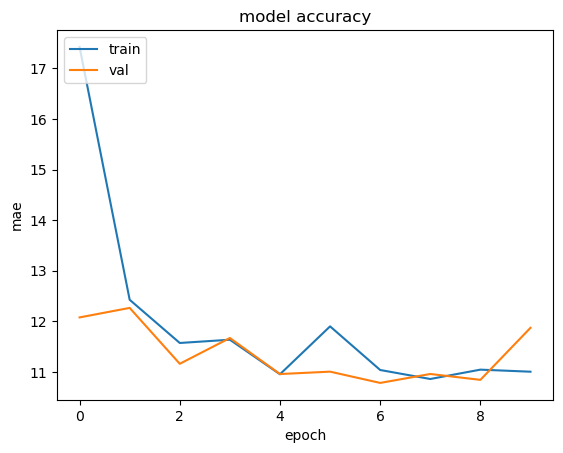

In [126]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

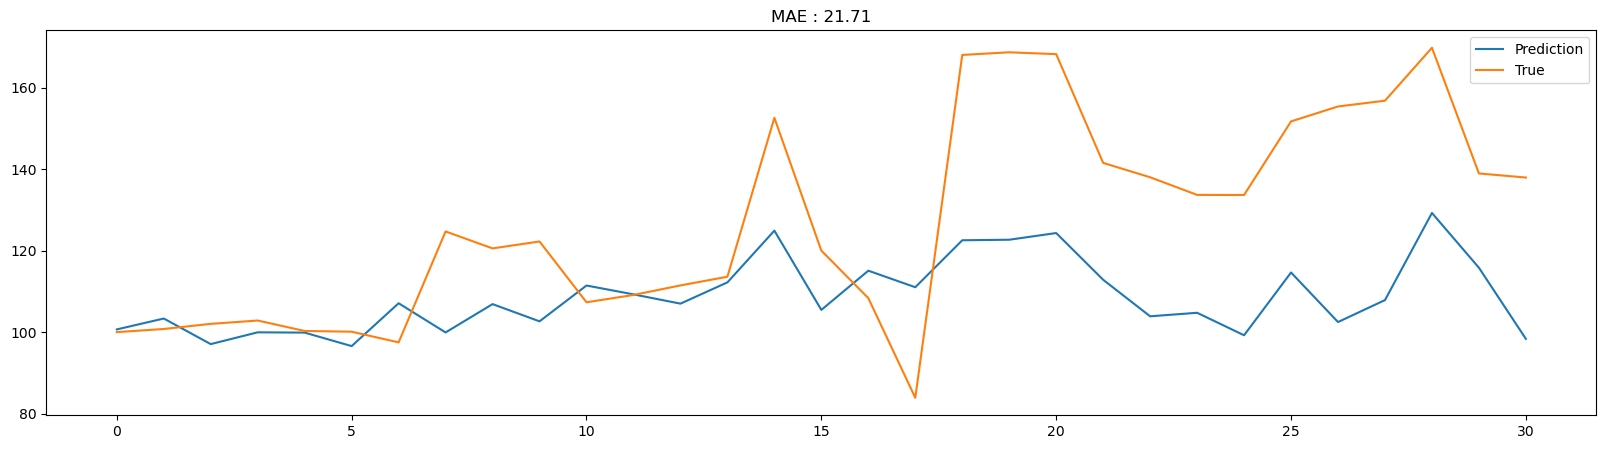

In [127]:
plt.figure(figsize=(20, 5))
plt.plot(y_pred, label='Prediction')
plt.plot(y_test, label='True')
plt.legend()
plt.title(f"MAE : {result[1]:.2f}")
plt.show()


Absolute error: mean 21.71, std 17.02, min 0.15, max 52.94
26 p000033_1 [0, 360]
11 p000033_1 [0, 360]


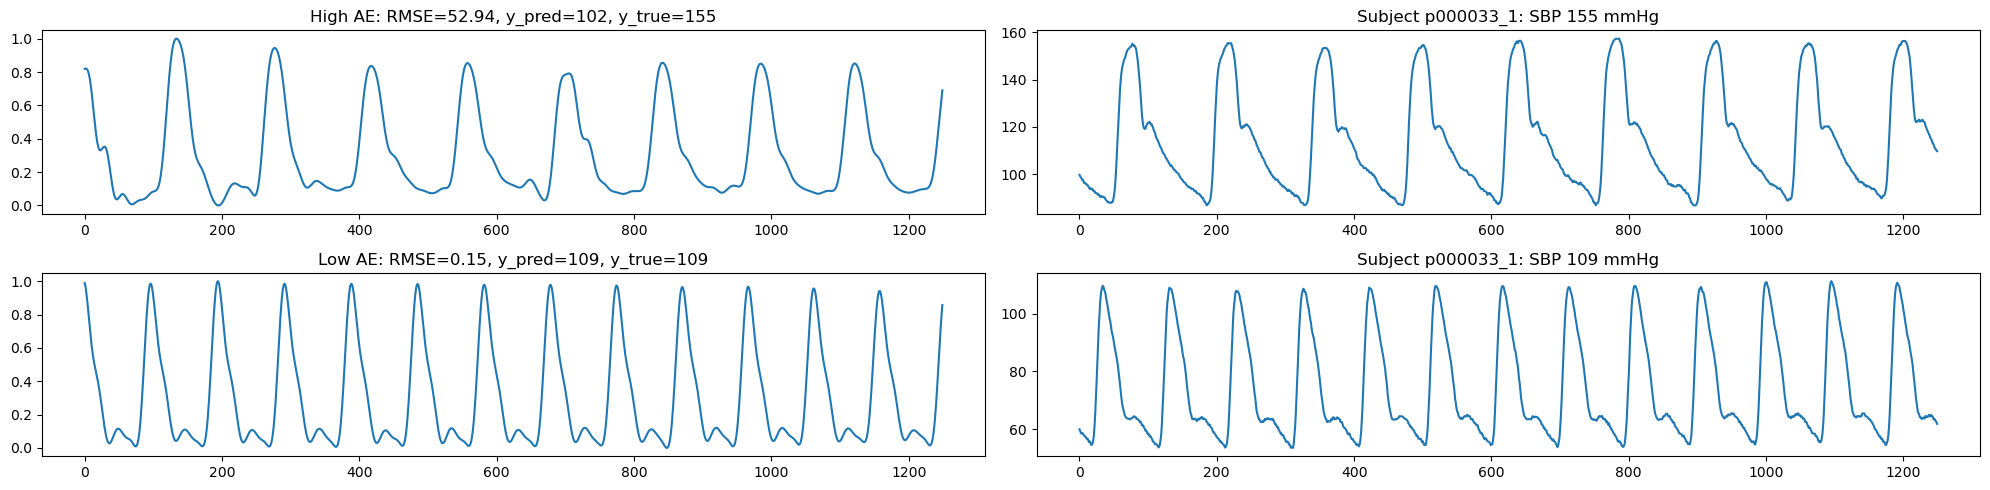

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def get_signal_index(index, subjects, indices):
    for key, val in subjects.items():
        if val[0] <= index <= val[-1]:
            print(index, key, val)  
            # return key, indices[key][index % 360]
            return key, index

abs_error = np.abs(y_pred - y_test)
print(f"Absolute error: mean {np.mean(abs_error):.2f}, std {np.std(abs_error):.2f}, min {np.min(abs_error):.2f}, max {np.max(abs_error):.2f}")

fig, axs = plt.subplots(2, 2, figsize=(20, 5))
pred_high_index = np.argmax(abs_error) # pred_high_index = np.random.choice(np.where(abs_error > 30)[0])
high_subj, high_index = get_signal_index(pred_high_index, testSubjects, TestIndices)
axs[0,0].plot(X_test[pred_high_index], label='High RMSE')
axs[0,0].set_title(f"High AE: RMSE={np.round(abs_error[pred_high_index],2)}, y_pred={int(y_pred[pred_high_index])}, y_true={int(y_test[pred_high_index])}")
axs[0,1].plot(TestSignals[high_index][ABP])
axs[0,1].set_title(f"Subject {high_subj}: SBP {int(TestSBPLabels[high_index])} mmHg")

pred_low_index = np.argmin(abs_error) # pred_low_index = np.random.choice(np.where(abs_error <= 10)[0])
low_subj, low_index = get_signal_index(pred_low_index, testSubjects, TestIndices)
axs[1,0].plot(X_test[pred_low_index], label='Low RMSE')
axs[1,0].set_title(f"Low AE: RMSE={np.round(abs_error[pred_low_index],2)}, y_pred={int(y_pred[pred_low_index])}, y_true={int(y_test[pred_low_index])}")
axs[1,1].plot(TestSignals[low_index][ABP])
axs[1,1].set_title(f"Subject {low_subj}: SBP {int(TestSBPLabels[low_index])} mmHg")

plt.tight_layout()
plt.show()


C:\Users\erolland\AppData\Local\Temp\3\ipykernel_1892\4211882408.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['BP_mean'] = df.groupby('BP_range')['abs_error'].transform('mean')


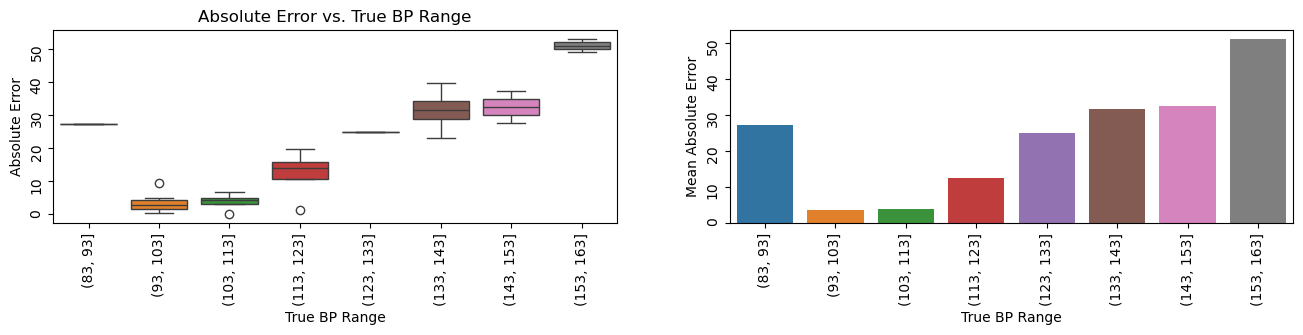

In [131]:
df = pd.DataFrame({'y_pred': y_pred, 'y_true': y_test, 'abs_error': abs_error})
df['BP_range'] = pd.cut(df['y_true'], bins=range(int(df.y_true.min()),int(df.y_true.max())+1,10))
df['BP_mean'] = df.groupby('BP_range')['abs_error'].transform('mean')

fig, ax = plt.subplots(1,2, figsize=(16, 2.5))
box = sns.boxplot(x='BP_range', y='abs_error', data=df, hue='BP_range', ax=ax[0])
box.set_xlabel('True BP Range')
box.set_ylabel('Absolute Error')
box.set_title('Absolute Error vs. True BP Range')
box.tick_params(labelrotation=90)
box.legend_.remove()

bar = sns.barplot(x='BP_range', y='BP_mean', data=df, hue='BP_range', ax=ax[1])
bar.set_xlabel('True BP Range')
bar.set_ylabel('Mean Absolute Error')
bar.tick_params(labelrotation=90)
bar.legend_.remove()

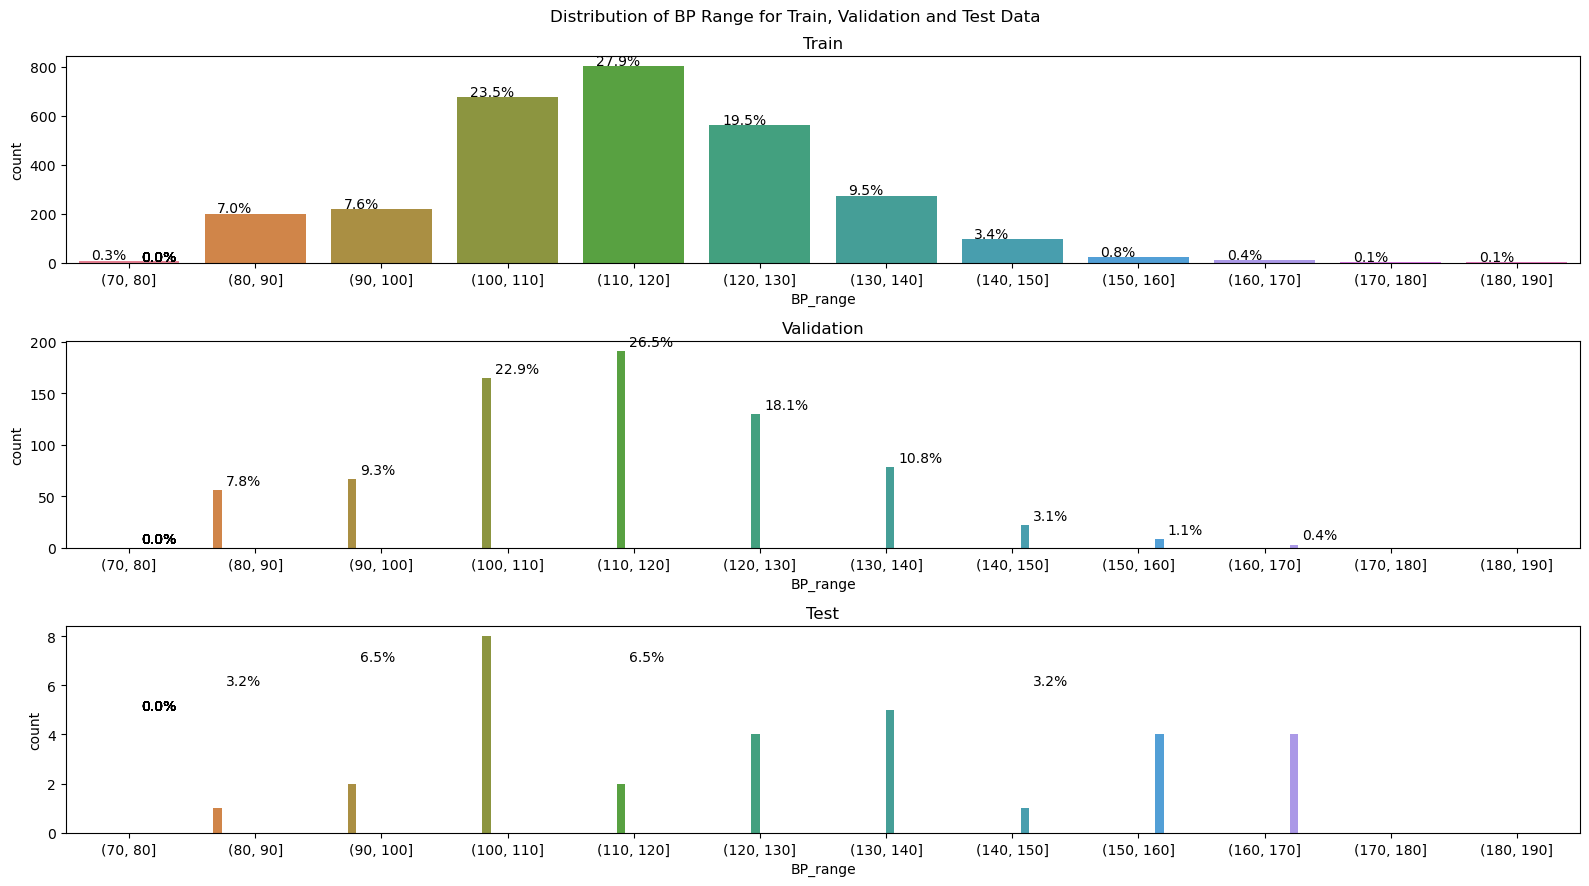

In [132]:
fig, axs = plt.subplots(3,1, figsize=(16, 9))  

for i,data_split in enumerate(['Train', 'Validation', 'Test']):
    y = y_train if data_split == 'Train' else y_val if data_split == 'Validation' else y_test
    df = pd.DataFrame({f'y': y})
    df['BP_range'] = pd.cut(df['y'], bins=range(70, 200, 10))
    bar = sns.countplot(x='BP_range', data=df, hue='BP_range', ax=axs[i])
    for p in bar.patches:
        bar.annotate('{:.1f}%'.format(100*p.get_height()/len(df)), (p.get_x()+0.1, p.get_height()+5))
    bar.legend_.remove()
    bar.set_title(f'{data_split.capitalize()}')
fig.suptitle('Distribution of BP Range for Train, Validation and Test Data')
plt.tight_layout()
plt.show()

# Info

In [7]:
info = loadmat('D:/PulseDB/Info_Files/Train_Info.mat')

KeyboardInterrupt: 

In [ ]:
print(info.keys())
print(info['Train_Subset'].keys())
print(len(info['Train_Subset']['Subj_Name']))
print(info['Train_Subset']['Subj_Name'][0], info['Train_Subset']['Subj_SegIDX'][0])
print(info['Train_Subset']['Subj_Age'][0], info['Train_Subset']['Subj_BMI'][0], info['Train_Subset']['Subj_Gender'][0], info['Train_Subset']['Subj_Height'][0], info['Train_Subset']['Subj_Weight'][0])
print(info['Train_Subset']['Source'][0]) 
print(info['Train_Subset']['Seg_SBP'][0])


dict_keys(['Train_Subset'])
dict_keys(['Seg_DBP', 'Seg_SBP', 'Source', 'Subj_Age', 'Subj_BMI', 'Subj_Gender', 'Subj_Height', 'Subj_Name', 'Subj_SegIDX', 'Subj_Weight'])
902160
['p000188_0'] [array(2833.)]
[array(57.)] [array(nan)] ['M'] [array(nan)] [array(nan)]
['MIMIC']
[array(100.24998388)]


In [ ]:
indices = [index for index, value in enumerate(info['Train_Subset']['Subj_Name']) if value[0] == 'p000188_0']
print(len(indices))

360
